# pretty plots


---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=2)
w = cluster.scale(5)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.39.90:56211 Dashboard: http://10.135.39.90:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

# 0: load path


In [5]:
grd = load_grd()
#ds = load_datanc(['SSU','SSV'], suff='_t000022*.nc')
ds = xr.merge(load_data(['SSU','SSV']))
#ds = xr.concat([xr.open_zarr(work_data_dir+'rechunked/') for face in range(13)],dim='face')
ds = xr.merge([grd,ds])
#ds = ds.assign_coords(CS=grd.CS, SN=grd.SN)
#ds =xr.merge(grd['CS'],ds)
print(ds)
print('\n data size (all faces): %.1f GB' %(ds['SSU'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SSU'].isel(face=1).nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8785)
Coordinates:
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    PHrefC   (k) float32 dask.array<shape=(90,), chunksize=(90,)>
    PHrefF   (k_p1) float32 dask.array<shape=(91,), chunksize=(91,)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Z        (k) float32 dask.array<shape=(9

In [6]:
ds = ds.isel(time=0).load()
sli = slice(0,None,4) # required to make worldwide plots, otherwise, half the globe is plotted
ds = ds.isel(i=sli, j=sli, i_g=sli, j_g=sli)
#
ds = ds.drop('dtime') # tmp leads to serialization issue at plots
#
#ds.persist()
#
print(ds)
print('\n dataset size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, i_g: 1080, j: 1080, j_g: 1080, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
    CS       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Depth    (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    PHrefC   (k) float32 4.905 15.4017 27.3699 ... 57701.242 61814.625 66317.266
    PHrefF   (k_p1) float32 0.0 9.81 20.9934 ... 59665.105 63964.145 68670.39
    SN       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    XC       (face, j, i) float32 -114.93228 -114.93183 ... -114.52893
    XG       (face, j_g, i_g) float32 -115.0 -115.0 ... -113.9233 -114.462036
    YC       (face, j, i) float32 -88.17715 -88.18883 ... -88.16518 -88.165405
    YG       (face, j_g, i_g) float32 -88.17569 -88.18737 ... -88.163925
    Z        (k) float32 -0.5 -1.57 -2.79 -4.185 ... -5881.88 -6301.185 -6760.17
    Zl       (k_l) float32 0.0 -1.0 -2.14 -3.44 ... -5681.69 -6082.07 -6520.3
    Zp1      (k_p1

---

## compute and plot rotated currents


In [7]:
# should do proper grid interpolation instead of renaming
U =  ds.SSU.rename({'i_g': 'i'})*ds.CS - ds.SSV.rename({'j_g': 'j'})*ds.SN
V =  ds.SSU.rename({'i_g': 'i'})*ds.SN + ds.SSV.rename({'j_g': 'j'})*ds.CS
U.persist()
V.persist()

<xarray.DataArray (face: 13, j: 1080, i: 1080)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.024259, -0.042429, ..., -0.132872, -0.134566],
        [ 0.039843,  0.028321, ..., -0.122766, -0.160034]],

       [[ 0.052999,  0.010986, ..., -0.057707, -0.130836],
        [ 0.059314,  0.056675, ..., -0.006945, -0.061761],
        ...,
        [-0.061491, -0.007865, ..., -0.017194, -0.029014],
        [ 0.071186,  0.059667, ..., -0.03929 , -0.09488 ]],

       ...,

       [[-0.090431, -0.029452, ...,  0.02091 ,  0.071981],
        [-0.141374, -0.040616, ...,  0.079812,  0.077828],
        ...,
        [ 0.034032,  0.176944, ...,  0.256482,  0.197848],
        [ 0.098927,  0.07821 , ...,  0.129264,  0.085731]],

       [[ 0.067745,  0.115851, ...,       nan,       nan],
        [ 0.105105,  0.112423, ...,       nan,       nan],
        ...,
        [ 0.16069 ,  0.143089, ...,       nan,       na

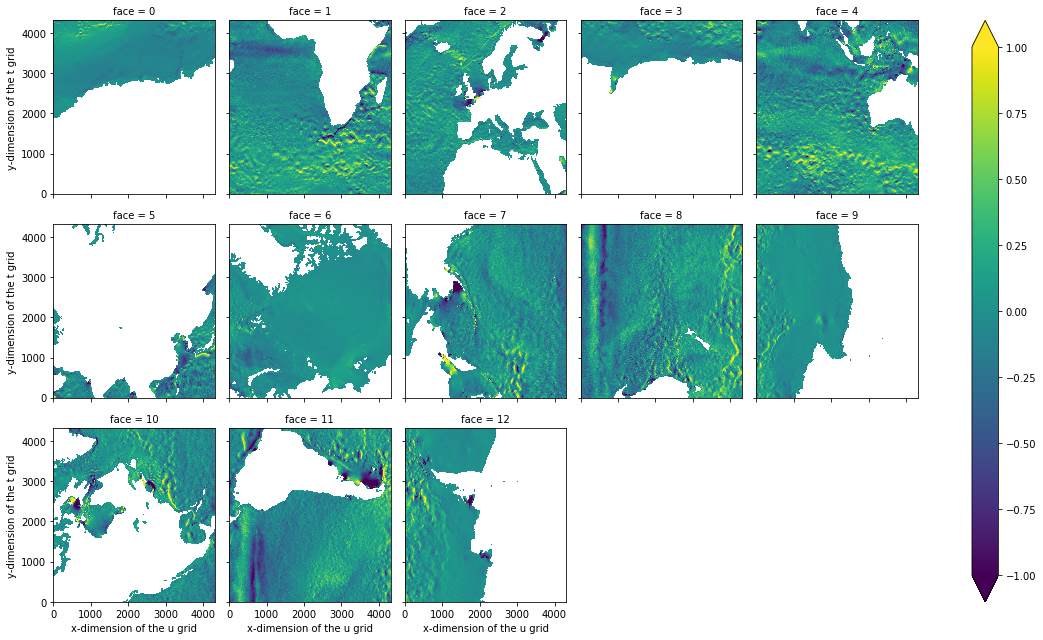

In [8]:
U.plot(col='face', col_wrap=5, vmin=-1., vmax=1.)

(<Figure size 432x288 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b4ce1d84b00>,
       dtype=object))

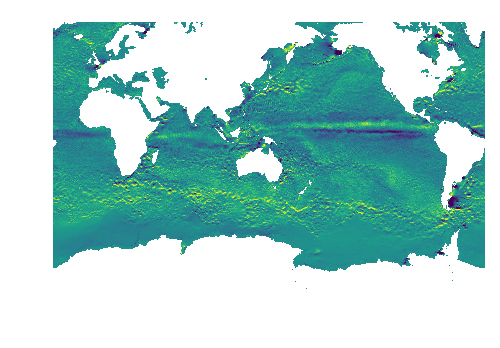

In [13]:
quick_llc_plot(U, vmin=-1., vmax=1., 
               add_colorbar=False, axis_off=True)

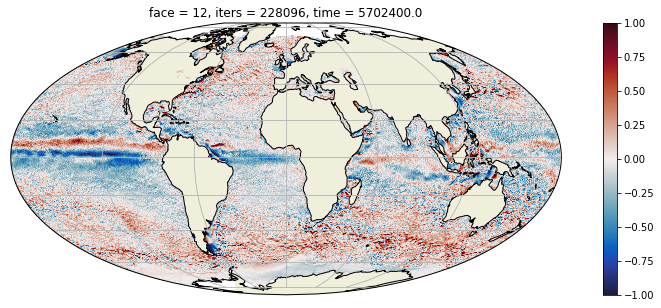

In [27]:
def plot_pretty(v, colorbar=False, title=None, vmin=None, vmax=None, savefig=None, 
                offline=False, coast_resolution='110m', figsize=(15,5), cmmap='thermal',
                ignore_face=[]):
    # should add projection as an input
    # should allow for zooms: atlantic, pacific, north-atlantic, ...
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        #ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
        #ax = fig.add_subplot(111, projection=ccrs.Robinson())
        ax = fig.add_subplot(111, projection=ccrs.Mollweide())
        #ax.set_extent([-180,180,-60,60])
        #ax = fig.add_subplot(111)
        # add colors over land:
        #ax.stock_img()
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>0) & (vplt.XC<179.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                #im = v.plot.pcolormesh(ax=ax, add_colorbar=False, cmap=cmap)
        fig.colorbar(im)
        # grid lines:
        ax.gridlines()
        # only with platecarre
        #gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
        #                alpha=0.5, linestyle='--')
        #gl.xlabels_top = False
        # coastlines and land:
        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)
        #
        if title is not None:
            ax.set_title(title)
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            
#plot_pretty(U.isel(face=[1,7]), vmin=-1., vmax=1., cmmap='balance', ignore_face=[6])
plot_pretty(U, vmin=-1., vmax=1., cmmap='balance', ignore_face=[6])


---

In [28]:
# kill scheduler, workers
cluster.close()

Exception ignored in: <generator object add_client at 0x2b5967efb6d0>
RuntimeError: generator ignored GeneratorExit
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/utils.py", line 646, in log_errors
    yield
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/client.py", line 844, in _reconnect
    yield self._ensure_connected()
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/client.py", line 875, in _ensure_connected
    assert len(msg) == 1
AssertionError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/mp/pontea/.con

In [ ]:
# restart workers
client.restart()

In [ ]:
client